In [171]:
import pandas as pd
import numpy as np
import math as m

from random import seed
from random import random as rand
import seaborn as sns
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
from ipywidgets import interact
from PIL import Image, ImageOps

seed(42)

In [220]:
class IsingModel :
    def __init__ (self, size, J=1.0, T=2.0) :
        #takes the size of the array
        self.size = size
        #creates array from the size
        self.lattice = np.full((self.size, self.size), -1)
        #interaction parameter
        self.J = J
        #the temperature of the field
        self.T = T
        
    def PickSite(self) :
        #picks random sites x and y
        x_index = np.random.randint(0, self.size)
        y_index = np.random.randint(0, self.size)
        site_pair = (x_index, y_index)
        return site_pair

    def Infect(self, coordinates, infection_type) :
        #infects the site selected. infection_type can be -1 or 1
        self.lattice[coordinates] = infection_type
        return self.lattice
    
    def CalcEnergy(self) :
        #calculates the Hamiltonian
        lat = self.lattice
        size = self.size
        J = self.J
        #initiates the interaction lattice
        interacting_neighbors_lattice = np.zeros(shape=(size,size))
        for i in range(0, size) :
            for j in range(0, size) :
                #populates the interaction values with imposed circular bounds
                interacting_neighbors_lattice[i, j] = lat[i, j]*(lat[i%size, (j-1)%size] + lat[i%size, (j+1)%size] + lat[(i-1)%size, j%size] + lat[(i+1)%size, j%size])
        #returns the sum of the lattice
        return -J*interacting_neighbors_lattice.sum()
    
    def TallySI(self) :
        #tallies the unique values in the array
        (val, count) = np.unique(self.lattice, return_counts=True)
        f = np.asarray((val, count)).T
        # handles cases at which the count is just either all -1 or 1
        if f.shape == (1,2) :
            if f[0][0] == -1 :
                return(self.size**2, 0)
            elif f[0][0] == 1 :
                return (0, self.size**2)
        else :
            #otherwise, I return the array values
            return (f[0][1], f[1][1])

    def PvRN(self, h_0, h) :
        #generates a random number, r
        r = rand()
        #calculates the probability equation of the field
        p = m.exp((h_0 - h)/self.T)
        if r <= p :
            return True
        else :
            return False
            
        

In [238]:
def display_lattice_interactive(imgs):
    #shows the iteration images with adjustment dial
    def _show(frame=(0, len(imgs) - 1)):
        return draw_lattice(imgs[frame])
    return interact(_show)

#draws the image from the lattice
def draw_lattice(lattice) :
    image = Image.fromarray(np.uint8((lattice - 1) * 0.5 * -255))
    image = image.resize((200, 200), Image.NEAREST)
    img_with_border = ImageOps.expand(image,border=2,fill='black')
    return img_with_border

In [276]:
results = pd.DataFrame(columns=['i', 'S', 'I', 'h_0', 'h'])

arr = IsingModel(50, T=2.00)
first_infective = arr.PickSite()
arr.Infect(first_infective, 1)

imgs = []
exit_counter = 0

for i in tqdm(range(0, 200000)):   
    h_0 = arr.CalcEnergy()
    site = arr.PickSite()
    if arr.lattice[site] == -1 :
        arr.Infect(site, 1)
        h = arr.CalcEnergy()
        if h_0 < h :
            if not arr.PvRN(h_0, h):
                arr.Infect(site, -1)
    if i%500 == 0 :
        tally = arr.TallySI()
        dictoappend = {'i': int(i), 'S': tally[0], 'I' : tally[1], 'h_0' : h_0, 'h': h}
        if tally[0] == 0 :
            exit_counter += 1
        if exit_counter == 10 :
            break
        results = results.append(dictoappend, ignore_index=True)
        imgs.append(arr.lattice.copy())
    draw_lattice(arr.lattice)

results = results.astype({'i': int})
results.set_index('i', inplace=True)


In [277]:
display_lattice_interactive(imgs)

interactive(children=(IntSlider(value=199, description='frame', max=399), Output()), _dom_classes=('widget-int…

<function __main__.display_lattice_interactive.<locals>._show(frame=(0, 399))>

In [278]:
results

,S,I,h_0,h
i,,,,
0,9999.0,1.0,-39984.0,-39968.0
500,9999.0,1.0,-39984.0,-39968.0
1000,9999.0,1.0,-39984.0,-39968.0
1500,9998.0,2.0,-39968.0,-39952.0
2000,9998.0,2.0,-39968.0,-39952.0
...,...,...,...,...
197500,9835.0,165.0,-38600.0,-38584.0
198000,9834.0,166.0,-38600.0,-38584.0
198500,9833.0,167.0,-38592.0,-38584.0


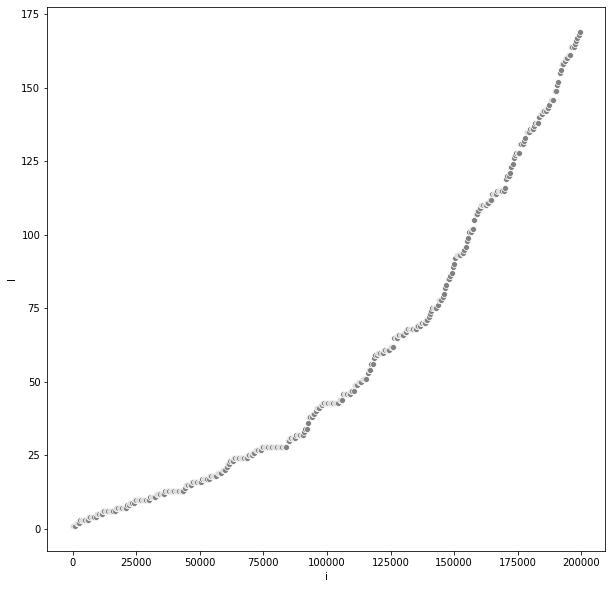

In [279]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=results.index, y='I', data=results, color='grey')

#colors = {'Susceptible':'red', 'Infected':'blue'}         
#labels = list(colors.keys())
#handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#plt.legend(handles, labels, loc='lower right')